In [3]:
# ====================== IMPORTS DAN SETUP ======================
import warnings
warnings.filterwarnings("ignore")

import os, re
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import silhouette_score

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

import nltk
try:
    nltk.data.find("tokenizers/punkt")
except:
    nltk.download("punkt")

# Direktori utama tempat semua file data Anda berada
DATA_DIR = Path("/COVEda/") 

# Set paths to your files - Sesuai de|ngan penyimpanan /COVEda/
# Kami menggabungkan DATA_DIR dengan nama file yang Anda berikan
files = {
    "iris": DATA_DIR / "1) iris.csv",
    "sentiment": DATA_DIR / "3) Sentiment dataset.csv",
    "house": DATA_DIR / "4) house Prediction Data Set.csv",
    "churn20": DATA_DIR / "churn-bigml-20.csv",
    "churn80": DATA_DIR / "churn-bigml-80.csv",
}

out_dir = Path("project_outputs")
out_dir.mkdir(parents=True, exist_ok=True)
print("Outputs will be saved to", out_dir.resolve())
print("\nData files are expected to be in:", DATA_DIR.resolve())
# Contoh cara memuat file: df_iris = pd.read_csv(files["iris"])

Outputs will be saved to C:\Users\user\project_outputs

Data files are expected to be in: C:\COVEda


In [4]:
# ====================== IMPORTS DAN SETUP (Disesuaikan) ======================
import warnings
warnings.filterwarnings("ignore")

import os, re
from pathlib import Path
import pandas as pd, numpy as np
# ... (impor lainnya) ...

# -------------------------------------------------------------
# PERBAIKAN PATH:
# Asumsikan folder 'COVEda' berada di direktori kerja saat ini
# atau sesuaikan path ini ke lokasi COVEda yang sebenarnya!
# Jika COVEda berada di folder yang sama dengan script ini, gunakan:
DATA_DIR = Path("COVEda") 
# JIKA COVEda berada di D drive, gunakan:
# DATA_DIR = Path("D:/COVEda/") 
# -------------------------------------------------------------

# Set paths to your files - Menggunakan DATA_DIR yang disesuaikan
files = {
    "iris": DATA_DIR / "1) iris.csv",
    "sentiment": DATA_DIR / "3) Sentiment dataset.csv",
    "house": DATA_DIR / "4) house Prediction Data Set.csv",
    "churn20": DATA_DIR / "churn-bigml-20.csv",
    "churn80": DATA_DIR / "churn-bigml-80.csv",
}

out_dir = Path("project_outputs")
out_dir.mkdir(parents=True, exist_ok=True)
print("Outputs will be saved to", out_dir.resolve())
print("\nData files are expected to be in:", DATA_DIR.resolve())


# ====================== LOAD DATASETS (Fungsi Asli Anda) ======================
print("=" * 60)
print("LOADING DATASETS")
print("=" * 60)

data = {}
for k, p in files.items():
    # Menggunakan Path(p).exists() memastikan jalur yang benar terlepas dari OS
    if Path(p).exists(): 
        try:
            data[k] = pd.read_csv(p)
            print(f"✓ Loaded {k}: {p}")
            print(f"  Shape: {data[k].shape}")
            print(f"  Columns: {list(data[k].columns)[:5]}...")
            print(f"  Missing values: {data[k].isna().sum().sum()}")
            print()
        except Exception as e:
            print(f"✗ Error loading {k} from {p}: {e} (skipping {k})\n")
    else:
        # Perhatikan bahwa p adalah objek Path, jika diubah ke string akan memberikan representasi jalur yang benar untuk OS
        print(f"✗ File not found: {p} (skipping {k})\n") 

print(f"Total datasets loaded: {len(data)}")
print("\nDataset previews:")
for name, df in data.items():
    print(f"\n{name.upper()}:")
    print(df.head(3))

Outputs will be saved to C:\Users\user\project_outputs

Data files are expected to be in: C:\Users\user\COVEda
LOADING DATASETS
✓ Loaded iris: COVEda\1) iris.csv
  Shape: (150, 5)
  Columns: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']...
  Missing values: 0

✓ Loaded sentiment: COVEda\3) Sentiment dataset.csv
  Shape: (732, 15)
  Columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp']...
  Missing values: 0

✓ Loaded house: COVEda\4) house Prediction Data Set.csv
  Shape: (505, 1)
  Columns: [' 0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30 396.90   4.98  24.00']...
  Missing values: 0

✓ Loaded churn20: COVEda\churn-bigml-20.csv
  Shape: (667, 20)
  Columns: ['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan']...
  Missing values: 0

✓ Loaded churn80: COVEda\churn-bigml-80.csv
  Shape: (2666, 20)
  Columns: ['State', 'Account length', 'Area code', 'International plan', 'Voice mail 

In [5]:
# ====================== TASK 1 : WEB SCRAPING WIKIPEDIA  ======================
print("=" * 60)
print("TASK 1 : WEB SCRAPING TABEL DARI WIKIPEDIA ")
print("=" * 60)

import requests
from bs4 import BeautifulSoup
import pandas as pd
from pathlib import Path
import time 

# URL target: Daftar negara dan dependensi berdasarkan populasi
WIKI_URL = "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"

# Direktori output
out_dir = Path("project_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------
# PENTING: MENAMBAHKAN USER-AGENT UNTUK MENGATASI 403
# User-Agent ini meniru browser Chrome di Windows
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
# -------------------------------------------------------------

print(f"Starting web scraping: {WIKI_URL}")
all_data = []

try:
    # Menggunakan header saat melakukan request
    response = requests.get(WIKI_URL, headers=headers, timeout=15)
    
    if response.status_code == 200:
        print("  Status Code 200: Koneksi berhasil.")
        soup = BeautifulSoup(response.text, "html.parser")
        
        table = soup.find("table", class_="wikitable")
        
        if table:
            rows = table.find_all("tr")
            
            # Mendapatkan header
            headers_table = [th.get_text(strip=True) for th in rows[0].find_all("th") if th.get_text(strip=True)]
            print(f"  Headers found: {headers_table}")

            # Iterasi melalui baris data
            for row in rows[1:]:
                # Tambahkan delay kecil (misalnya 0.1 detik) jika scraping banyak halaman, 
                # meskipun untuk satu halaman ini tidak terlalu penting, ini adalah praktik baik.
                # time.sleep(0.1) 
                
                cols = row.find_all("td")
                
                if cols:
                    data_row = [ele.get_text(strip=True) for ele in cols]
                    
                    if len(data_row) == len(headers_table):
                        all_data.append(data_row)
            
            print(f"\n✅ Scraping completed!")
            print(f"✅ Total rows collected: {len(all_data)}")
            
            df_wiki = pd.DataFrame(all_data, columns=headers_table)
            
            output_file = out_dir / "wiki_population_data_revised.csv"
            df_wiki.to_csv(output_file, index=False)
            
            print(f"✅ File saved to: {output_file.resolve()}")
            print("\nFirst 5 rows scraped:")
            print(df_wiki.head())
            
        else:
            print("✗ Tidak menemukan tabel dengan class 'wikitable' di halaman tersebut.")
            
    elif response.status_code == 403:
        print(f"✗ Gagal mengambil halaman. Status Code 403: Akses Ditolak (Forbidden). Coba User-Agent yang berbeda.")
    else:
        print(f"✗ Gagal mengambil halaman. Status Code: {response.status_code}")

except requests.exceptions.RequestException as e:
    print(f"✗ Terjadi kesalahan koneksi/timeout: {e}")

TASK 1 : WEB SCRAPING TABEL DARI WIKIPEDIA 
Starting web scraping: https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population
  Status Code 200: Koneksi berhasil.
  Headers found: ['Location', 'Population', '% ofworld', 'Date', 'Source (official or fromtheUnited Nations)', 'Notes']

✅ Scraping completed!
✅ Total rows collected: 240
✅ File saved to: C:\Users\user\project_outputs\wiki_population_data_revised.csv

First 5 rows scraped:
        Location     Population % ofworld         Date  \
0          World  8,232,000,000      100%  13 Jun 2025   
1          India  1,417,492,000     17.2%   1 Jul 2025   
2          China  1,408,280,000     17.1%  31 Dec 2024   
3  United States    340,110,988      4.1%   1 Jul 2024   
4      Indonesia    284,438,782      3.5%  30 Jun 2025   

  Source (official or fromtheUnited Nations) Notes  
0                        UN projection[1][3]        
1                     Official projection[4]   [b]  
2                       Official es

In [6]:
# ====================== TASK 2: DATA CLEANING ======================
print("=" * 60)
print("TASK 2: DATA CLEANING & PREPROCESSING")
print("=" * 60)

cleaned = {}
for name, df in data.items():
    print(f"\n{'─' * 40}")
    
    print(f"CLEANING DATASET: {name.upper()}")
    print(f"Initial shape: {df.shape}")
    
    dfc = df.copy()
    
    # 1. Missing values report
    miss = dfc.isna().sum()
    miss_total = miss.sum()
    print(f"Missing values total: {miss_total}")
    if miss_total > 0:
        print("Columns with missing values:")
        for col, count in miss[miss > 0].items():
            print(f"  {col}: {count} missing ({count/len(dfc)*100:.1f}%)")
    
    # 2. Impute missing values
    num_cols = dfc.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = dfc.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if num_cols:
        imputer_num = SimpleImputer(strategy='median')
        dfc[num_cols] = imputer_num.fit_transform(dfc[num_cols])
        print(f"Imputed {len(num_cols)} numeric columns with median")
    
    if cat_cols:
        imputer_cat = SimpleImputer(strategy='most_frequent')
        dfc[cat_cols] = imputer_cat.fit_transform(dfc[cat_cols])
        print(f"Imputed {len(cat_cols)} categorical columns with mode")
    
    # 3. Remove duplicates
    before = dfc.shape[0]
    dfc = dfc.drop_duplicates().reset_index(drop=True)
    after = dfc.shape[0]
    dup_removed = before - after
    print(f"Duplicates removed: {dup_removed}")
    
    # 4. Outlier detection
    out_counts = {}
    for c in num_cols:
        Q1, Q3 = dfc[c].quantile(0.25), dfc[c].quantile(0.75)
        IQR = Q3 - Q1
        low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        outliers = ((dfc[c] < low) | (dfc[c] > high)).sum()
        if outliers > 0:
            out_counts[c] = int(outliers)
    
    if out_counts:
        print("Columns with outliers (IQR method):")
        for col, count in out_counts.items():
            print(f"  {col}: {count} outliers ({count/len(dfc)*100:.1f}%)")
    else:
        print("No outliers detected using IQR method")
    
    # Save cleaned data
    cleaned[name] = dfc
    dfc.to_csv(out_dir / f"{name}_cleaned.csv", index=False)
    print(f"✓ Cleaned dataset saved: {name}_cleaned.csv")
    print(f"Final shape: {dfc.shape}")

print(f"\n✅ All datasets cleaned! Total: {len(cleaned)} datasets")

TASK 2: DATA CLEANING & PREPROCESSING

────────────────────────────────────────
CLEANING DATASET: IRIS
Initial shape: (150, 5)
Missing values total: 0
Imputed 4 numeric columns with median
Imputed 1 categorical columns with mode
Duplicates removed: 3
Columns with outliers (IQR method):
  sepal_width: 4 outliers (2.7%)
✓ Cleaned dataset saved: iris_cleaned.csv
Final shape: (147, 5)

────────────────────────────────────────
CLEANING DATASET: SENTIMENT
Initial shape: (732, 15)
Missing values total: 0
Imputed 8 numeric columns with median
Imputed 7 categorical columns with mode
Duplicates removed: 0
Columns with outliers (IQR method):
  Retweets: 18 outliers (2.5%)
  Likes: 18 outliers (2.5%)
  Year: 11 outliers (1.5%)
  Hour: 5 outliers (0.7%)
✓ Cleaned dataset saved: sentiment_cleaned.csv
Final shape: (732, 15)

────────────────────────────────────────
CLEANING DATASET: HOUSE
Initial shape: (505, 1)
Missing values total: 0
Imputed 1 categorical columns with mode
Duplicates removed: 0
No 

TASK 3: EXPLORATORY DATA ANALYSIS (EDA)

────────────────────────────────────────
EDA FOR: IRIS
Numeric columns: 4
Categorical columns: 1

📊 Basic Statistics:
              count      mean       std  min  50%  max  skewness
sepal_length  147.0  5.856463  0.829100  4.3  5.8  7.9  0.292560
sepal_width   147.0  3.055782  0.437009  2.0  3.0  4.4  0.324351
petal_length  147.0  3.780272  1.759111  1.0  4.4  6.9 -0.293763
petal_width   147.0  1.208844  0.757874  0.1  1.3  2.5 -0.113479

📈 Correlation Matrix (shape: (4, 4))
High correlations (>0.7):
  sepal_length ↔ petal_length: 0.871
  sepal_length ↔ petal_width: 0.817
  petal_length ↔ petal_width: 0.962


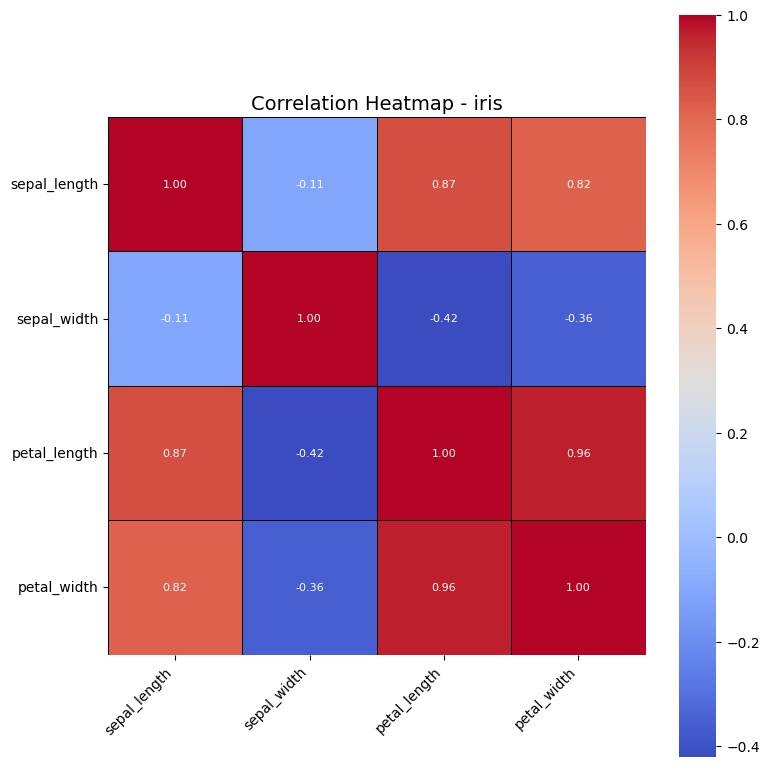

✓ Saved High-Resolution Correlation Heatmap.


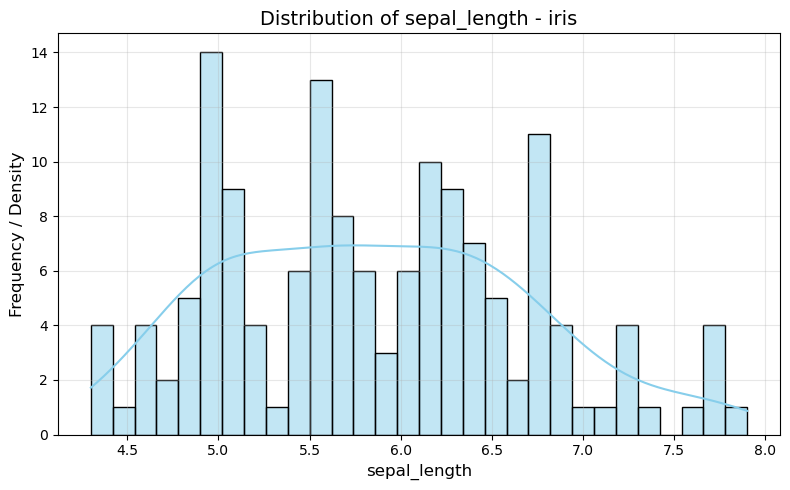

✓ Saved Distribution Plot for sepal_length.
✓ EDA completed for iris
✓ Files saved: iris_numeric_stats.csv, iris_corr_matrix.csv, [name]_corr_heatmap.png, [name]_distribution.png

────────────────────────────────────────
EDA FOR: SENTIMENT
Numeric columns: 8
Categorical columns: 7

📊 Basic Statistics:
              count         mean         std     min     50%     max  skewness
Unnamed: 0.1  732.0   366.464481  211.513936     0.0   366.5   732.0 -0.000908
Unnamed: 0    732.0   369.740437  212.428936     0.0   370.5   736.0 -0.008058
Retweets      732.0    21.508197    7.061286     5.0    22.0    40.0  0.363412
Likes         732.0    42.901639   14.089848    10.0    43.0    80.0  0.378139
Year          732.0  2020.471311    2.802285  2010.0  2021.0  2023.0 -1.029292

📈 Correlation Matrix (shape: (8, 8))
High correlations (>0.7):
  Unnamed: 0.1 ↔ Unnamed: 0: 1.000
  Retweets ↔ Likes: 0.998


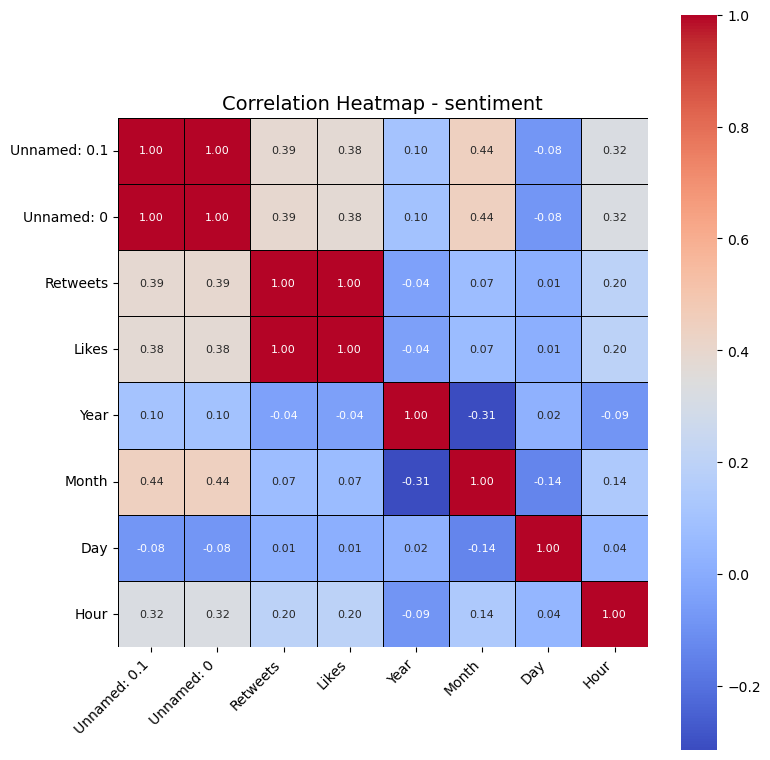

✓ Saved High-Resolution Correlation Heatmap.


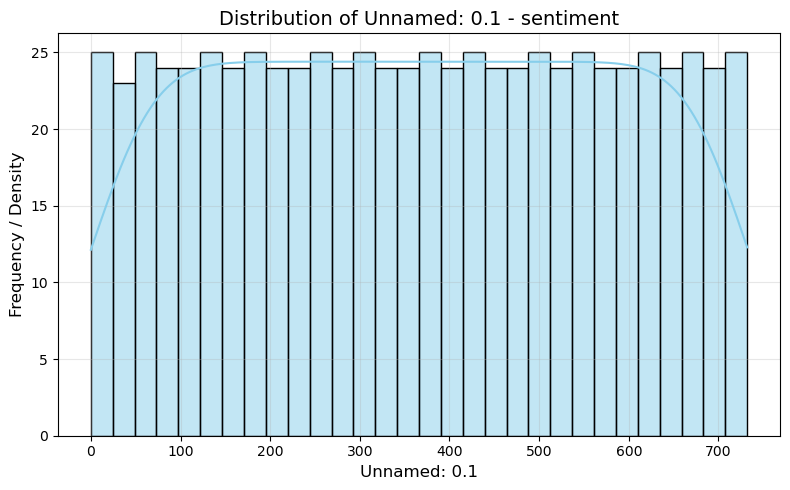

✓ Saved Distribution Plot for Unnamed: 0.1.
✓ EDA completed for sentiment
✓ Files saved: sentiment_numeric_stats.csv, sentiment_corr_matrix.csv, [name]_corr_heatmap.png, [name]_distribution.png

────────────────────────────────────────
EDA FOR: HOUSE
Numeric columns: 0
Categorical columns: 1
No numeric columns for EDA

────────────────────────────────────────
EDA FOR: CHURN20
Numeric columns: 16
Categorical columns: 3

📊 Basic Statistics:
                       count        mean        std    min    50%    max  \
Account length         667.0  102.841079  40.819480    1.0  102.0  232.0   
Area code              667.0  436.157421  41.783305  408.0  415.0  510.0   
Number vmail messages  667.0    8.407796  13.994480    0.0    0.0   51.0   
Total day minutes      667.0  180.948126  55.508628   25.9  178.3  334.3   
Total day calls        667.0  100.937031  20.396790   30.0  101.0  165.0   

                       skewness  
Account length         0.153390  
Area code              1.194561 

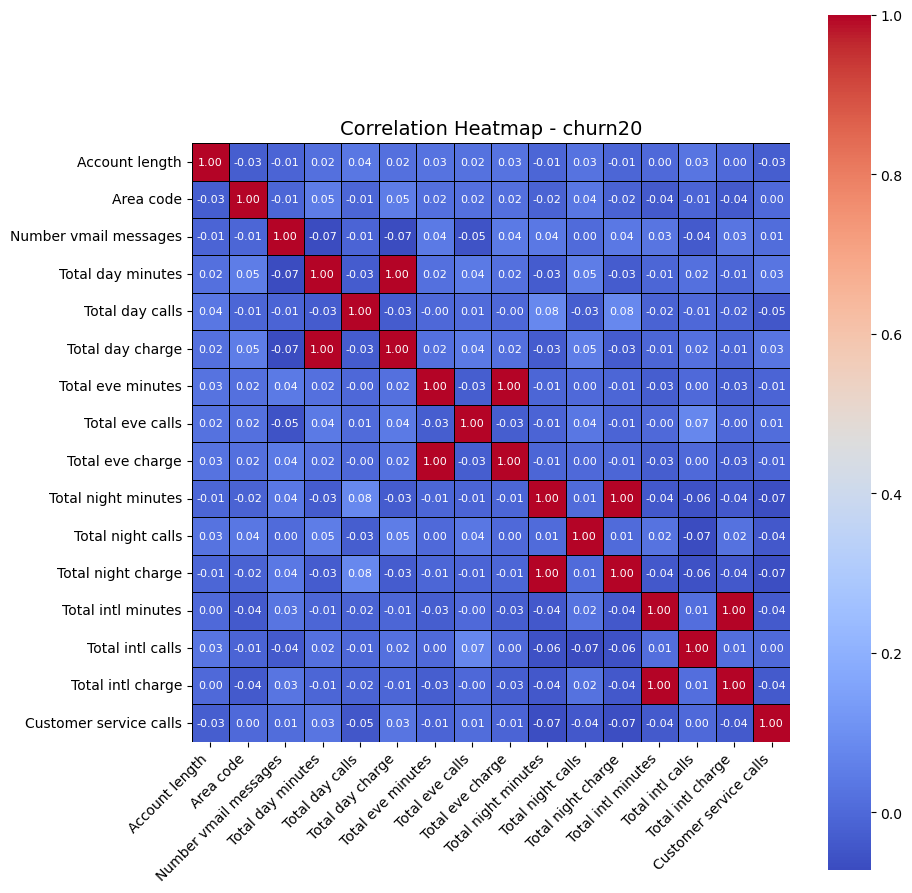

✓ Saved High-Resolution Correlation Heatmap.


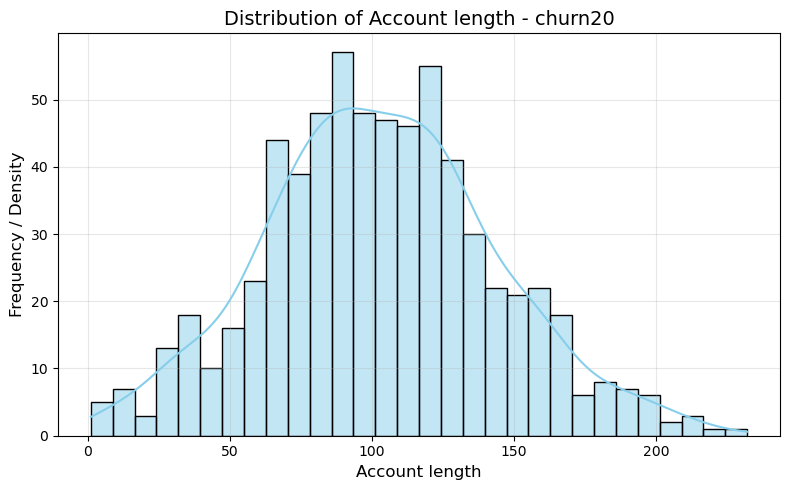

✓ Saved Distribution Plot for Account length.
✓ EDA completed for churn20
✓ Files saved: churn20_numeric_stats.csv, churn20_corr_matrix.csv, [name]_corr_heatmap.png, [name]_distribution.png

────────────────────────────────────────
EDA FOR: CHURN80
Numeric columns: 16
Categorical columns: 3

📊 Basic Statistics:
                        count        mean        std    min     50%    max  \
Account length         2666.0  100.620405  39.563974    1.0  100.00  243.0   
Area code              2666.0  437.438860  42.521018  408.0  415.00  510.0   
Number vmail messages  2666.0    8.021755  13.612277    0.0    0.00   50.0   
Total day minutes      2666.0  179.481620  54.210350    0.0  179.95  350.8   
Total day calls        2666.0  100.310203  19.988162    0.0  101.00  160.0   

                       skewness  
Account length         0.079023  
Area code              1.110965  
Number vmail messages  1.271774  
Total day minutes     -0.053106  
Total day calls       -0.128267  

📈 Correlation

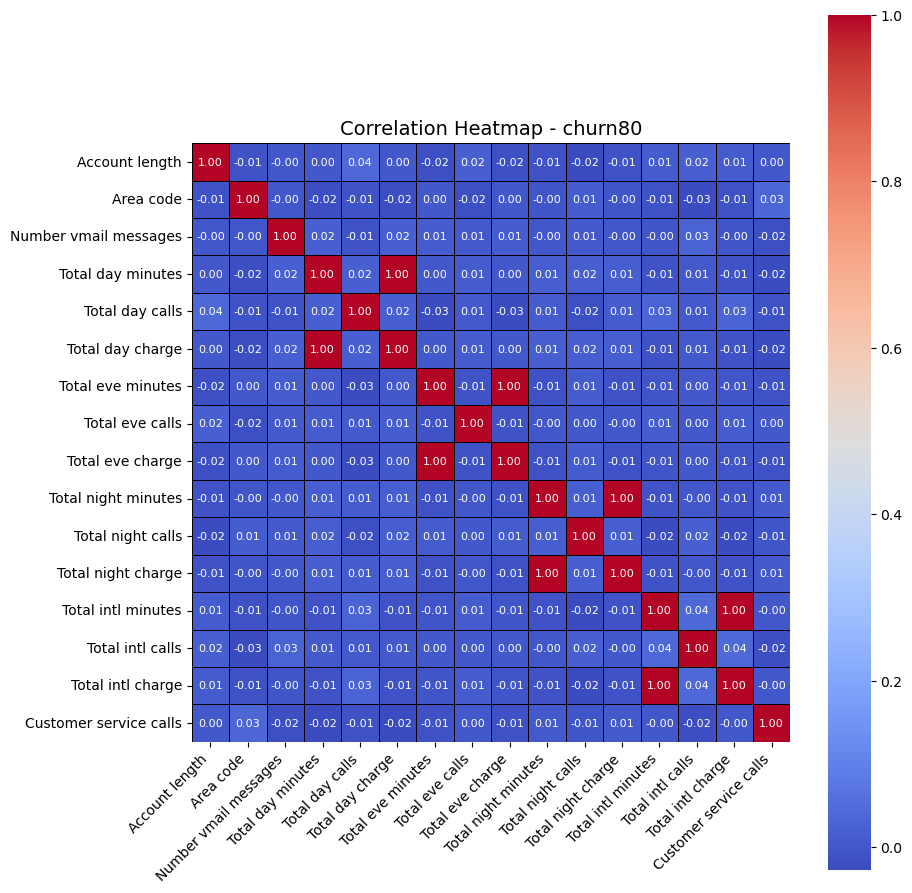

✓ Saved High-Resolution Correlation Heatmap.


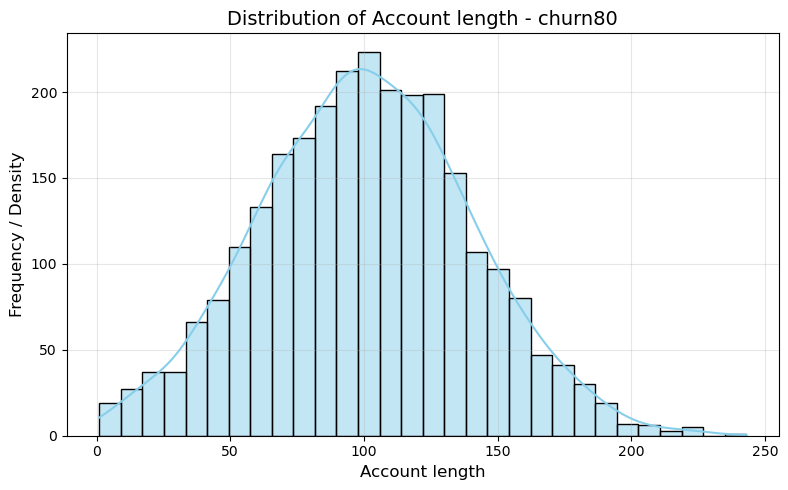

✓ Saved Distribution Plot for Account length.
✓ EDA completed for churn80
✓ Files saved: churn80_numeric_stats.csv, churn80_corr_matrix.csv, [name]_corr_heatmap.png, [name]_distribution.png

✅ EDA completed for all datasets!


In [7]:
    # ====================== TASK 3: EXPLORATORY DATA ANALYSIS ======================
    print("=" * 60)
    print("TASK 3: EXPLORATORY DATA ANALYSIS (EDA)")
    print("=" * 60)
    
    for name, df in cleaned.items():
        print(f"\n{'─' * 40}")
        print(f"EDA FOR: {name.upper()}")
        
        num_cols = df.select_dtypes(include=[np.number])
        cat_cols = df.select_dtypes(include=['object', 'category'])
        
        print(f"Numeric columns: {len(num_cols.columns)}")
        print(f"Categorical columns: {len(cat_cols.columns)}")
        
        if num_cols.shape[1] == 0:
            print("No numeric columns for EDA")
            continue
        
        # 1. Basic Statistics
        stats = num_cols.describe().T
        stats['missing'] = num_cols.isna().sum()
        stats['skewness'] = num_cols.skew()
        stats['kurtosis'] = num_cols.kurtosis()
        
        print("\n📊 Basic Statistics:")
        print(stats[['count', 'mean', 'std', 'min', '50%', 'max', 'skewness']].head())
        
        # Save statistics
        stats.to_csv(out_dir / f"{name}_numeric_stats.csv")
        
        # 2. Correlation Matrix
        corr = num_cols.corr()
        print(f"\n📈 Correlation Matrix (shape: {corr.shape})")
        
        # Find top correlations
        corr_triu = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        high_corr = []
        for col in corr_triu.columns:
            for idx in corr_triu.index:
                val = corr_triu.loc[idx, col]
                if abs(val) > 0.7 and not pd.isna(val):
                    high_corr.append((idx, col, val))
        
        if high_corr:
            print("High correlations (>0.7):")
            for col1, col2, val in high_corr[:5]:  # Show top 5
                print(f"  {col1} ↔ {col2}: {val:.3f}")
        
        # Save correlation matrix
        corr.to_csv(out_dir / f"{name}_corr_matrix.csv")
        
    # 3. Visualizations (REVISI BAGIAN INI UNTUK MENINGKATKAN KEJELASAN)
        
        # Heatmap Korelasi
        if len(num_cols.columns) > 1:
            # PENTING: Mengubah ukuran figure (figsize) menjadi lebih besar
            # Misalnya, 10x10 atau lebih besar, tergantung jumlah kolom
            num_vars = len(num_cols.columns)
            # Hitung ukuran figure yang dinamis (misalnya 0.6 kali jumlah variabel)
            fig_size = max(8, min(14, num_vars * 0.6)) 
            
            plt.figure(figsize=(fig_size, fig_size))
            
            # Menggunakan sns.heatmap secara langsung untuk kontrol penuh
            sns.heatmap(corr, 
                        annot=True,              # Menampilkan nilai korelasi
                        fmt=".2f",               # Format angka 2 desimal
                        cmap="coolwarm",         # Skema warna
                        cbar=True,               # Tampilkan color bar
                        square=True,             # Membuat sel persegi
                        linewidths=.5,           # Menambah garis pemisah
                        linecolor='black',
                        annot_kws={"size": 8}    # Mengurangi ukuran font anotasi jika perlu
                       )
            plt.title(f"Correlation Heatmap - {name}", fontsize=14)
            
            # Memutar label sumbu X agar tidak bertabrakan
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            
            plt.tight_layout()
            plt.savefig(out_dir / f"{name}_corr_heatmap.png", dpi=300) # Tingkatkan DPI untuk kualitas
            plt.show() 
            plt.close() # Tutup figure setelah save
            print("✓ Saved High-Resolution Correlation Heatmap.")
    
        
        # Distribusi Plot (Kita pertahankan histogram/distribusi, namun pisahkan figure-nya)
        if len(num_cols.columns) > 0:
            
            # PENTING: Gunakan figure terpisah untuk distribusi agar tidak bertabrakan
            plt.figure(figsize=(8, 5))
            
            sample_col = num_cols.columns[0]
            sns.histplot(df[sample_col].dropna(), bins=30, kde=True, 
                         color='skyblue', edgecolor='black')
            
            plt.xlabel(sample_col, fontsize=12)
            plt.ylabel('Frequency / Density', fontsize=12)
            plt.title(f'Distribution of {sample_col} - {name}', fontsize=14)
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(out_dir / f"{name}_distribution.png", dpi=300)
            plt.show()
            plt.close() # Tutup figure setelah save
            print(f"✓ Saved Distribution Plot for {sample_col}.")
    
        
        print(f"✓ EDA completed for {name}")
        # Catatan: Simpan file kini terpisah: [name]_corr_heatmap.png dan [name]_distribution.png
        print(f"✓ Files saved: {name}_numeric_stats.csv, {name}_corr_matrix.csv, [name]_corr_heatmap.png, [name]_distribution.png")
    
    print("\n✅ EDA completed for all datasets!")

In [8]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ====================== TASK 1: REGRESSION ANALYSIS (CHURN DATASET) ======================
print("=" * 60)
print("TASK 1: REGRESSION ANALYSIS (CUSTOMER CHURN)")
print("=" * 60)

# Folder sumber dataset
project_output_dir = Path("project_outputs")

# Cari file churn (csv / xlsx)
churn_file = None
for file in project_output_dir.glob("*churn*"):
    if file.suffix in [".csv", ".xlsx"]:
        churn_file = file
        break

# Jika tidak ada file ditemukan
if churn_file is None:
    print("✗ Tidak ditemukan file churn di folder project_outputs")
else:
    print(f"✓ File ditemukan: {churn_file.name}")

    # Load dataset sesuai tipe file
    if churn_file.suffix == ".csv":
        h = pd.read_csv(churn_file)
    else:
        h = pd.read_excel(churn_file)

    print(f"Dataset: churn")
    print(f"Shape: {h.shape}")
    print(f"Columns: {list(h.columns)}")

    # Ambil kolom numerik
    numeric = h.select_dtypes(include=[np.number]).columns.tolist()

    if len(numeric) <= 1:
        print("✗ Insufficient numeric features for regression (<=1 numeric column)")
    else:
        # Target = kolom numerik terakhir
        target = numeric[-1]
        print(f"Target variable selected: {target}")

        # Siapkan data
        X = h.drop(columns=[target])
        y = h[target].astype(float)

        # One-hot encode kategori
        X_proc = pd.get_dummies(X, drop_first=True).fillna(0)

        print(f"\nData preparation:")
        print(f"  Features (X): {X_proc.shape[1]} columns")
        print(f"  Target (y): {target}")
        print(f"  Sample size: {len(y)}")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_proc, y, test_size=0.2, random_state=42
        )

        models = {
            "Linear Regression": LinearRegression(),
            "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=5),
            "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42)
        }

        results = []

        for name, model in models.items():
            print(f"\n📊 Training {name}...")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            results.append({
                "Model": name,
                "MSE": round(mse, 2),
                "RMSE": round(rmse, 2),
                "R² Score": round(r2, 4),
                "Features": X_proc.shape[1]
            })

            print(f"  MSE: {mse:.2f}")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  R² Score: {r2:.4f}")

        results_df = pd.DataFrame(results)
        print("\nREGRESSION RESULTS SUMMARY:")
        print(results_df)

        # Simpan hasil ke folder output
        out_dir = Path("project_outputs")
        results_df.to_csv(out_dir / "churn_regression_results.csv", index=False)
        print("✓ Results saved: churn_regression_results.csv")


TASK 1: REGRESSION ANALYSIS (CUSTOMER CHURN)
✓ File ditemukan: churn20_cleaned.csv
Dataset: churn
Shape: (667, 20)
Columns: ['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']
Target variable selected: Customer service calls

Data preparation:
  Features (X): 68 columns
  Target (y): Customer service calls
  Sample size: 667

📊 Training Linear Regression...
  MSE: 1.93
  RMSE: 1.39
  R² Score: -0.2012

📊 Training Decision Tree...
  MSE: 1.81
  RMSE: 1.34
  R² Score: -0.1233

📊 Training Random Forest...
  MSE: 1.52
  RMSE: 1.23
  R² Score: 0.0538

REGRESSION RESULTS SUMMARY:
               Model   MSE  RMSE  R² Score  Features
0  Linear Regression  1.93 

In [ ]:
# import pandas as pd
# import numpy as np
# import os
# from pathlib import Path
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score

# # ====================== TASK 1: REGRESSION ANALYSIS (CHURN DATASET) ======================
# print("=" * 60)
# print("TASK 1: REGRESSION ANALYSIS (CUSTOMER CHURN)")
# print("=" * 60)

# # Folder sumber dataset
# project_output_dir = Path("project_outputs")

# # Cari file churn (csv / xlsx)
# churn_file = None
# for file in project_output_dir.glob("*churn*"):
#     if file.suffix in [".csv", ".xlsx"]:
#         churn_file = file
#         break

# # Jika tidak ada file ditemukan
# if churn_file is None:
#     print("✗ Tidak ditemukan file churn di folder project_outputs")
# else:
#     print(f"✓ File ditemukan: {churn_file.name}")

#     # Load dataset sesuai tipe file
#     if churn_file.suffix == ".csv":
#         h = pd.read_csv(churn_file)
#     else:
#         h = pd.read_excel(churn_file)

#     print(f"Dataset: churn")
#     print(f"Shape: {h.shape}")
#     print(f"Columns: {list(h.columns)}")

#     # Ambil kolom numerik
#     numeric = h.select_dtypes(include=[np.number]).columns.tolist()

#     if len(numeric) <= 1:
#         print("✗ Insufficient numeric features for regression (<=1 numeric column)")
#     else:
#         # Target = kolom numerik terakhir
#         target = numeric[-1]
#         print(f"Target variable selected: {target}")

#         # Siapkan data
#         X = h.drop(columns=[target])
#         y = h[target].astype(float)

#         # One-hot encode kategori
#         X_proc = pd.get_dummies(X, drop_first=True).fillna(0)

#         print(f"\nData preparation:")
#         print(f"  Features (X): {X_proc.shape[1]} columns")
#         print(f"  Target (y): {target}")
#         print(f"  Sample size: {len(y)}")

#         # Split data
#         X_train, X_test, y_train, y_test = train_test_split(
#             X_proc, y, test_size=0.2, random_state=42
#         )

#         models = {
#             "Linear Regression": LinearRegression(),
#             "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=5),
#             "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42)
#         }

#         results = []

#         for name, model in models.items():
#             print(f"\n📊 Training {name}...")
#             model.fit(X_train, y_train)
#             y_pred = model.predict(X_test)

#             mse = mean_squared_error(y_test, y_pred)
#             rmse = np.sqrt(mse)
#             r2 = r2_score(y_test, y_pred)

#             results.append({
#                 "Model": name,
#                 "MSE": round(mse, 2),
#                 "RMSE": round(rmse, 2),
#                 "R² Score": round(r2, 4),
#                 "Features": X_proc.shape[1]
#             })

#             print(f"  MSE: {mse:.2f}")
#             print(f"  RMSE: {rmse:.2f}")
#             print(f"  R² Score: {r2:.4f}")

#         results_df = pd.DataFrame(results)
#         print("\nREGRESSION RESULTS SUMMARY:")
#         print(results_df)

#         # Simpan hasil ke folder output
#         out_dir = Path("project_outputs")
#         results_df.to_csv(out_dir / "churn_regression_results.csv", index=False)
#         print("✓ Results saved: churn_regression_results.csv")


In [2]:
!pip install tensorflow

  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.2-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached grpcio-1.76.0-cp312-cp312-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.13.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached ml_dtypes-0.5.4-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\user\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^

TASK 2: CLASSIFICATION ANALYSIS (CHURN PREDICTION)
Dataset shape: (667, 20)
Target variable: Churn
✓ Feature reduced to 50
Total features used: 50

📊 Training Logistic Regression...
  Accuracy: 0.8507
  F1-Score: 0.2308

📊 Training Decision Tree...
  Accuracy: 0.9179
  F1-Score: 0.6452

📊 Training Random Forest...
  Accuracy: 0.8955
  F1-Score: 0.4615

CLASSIFICATION RESULTS SUMMARY
                 Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0  Logistic Regression  0.850746   0.428571  0.157895  0.230769  0.766590
1        Decision Tree  0.917910   0.833333  0.526316  0.645161  0.806865
2        Random Forest  0.895522   0.857143  0.315789  0.461538  0.910297

Best Model: Decision Tree


<Figure size 1000x500 with 0 Axes>

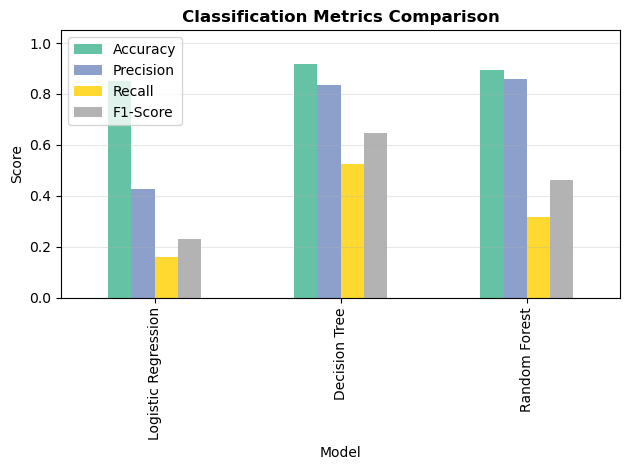

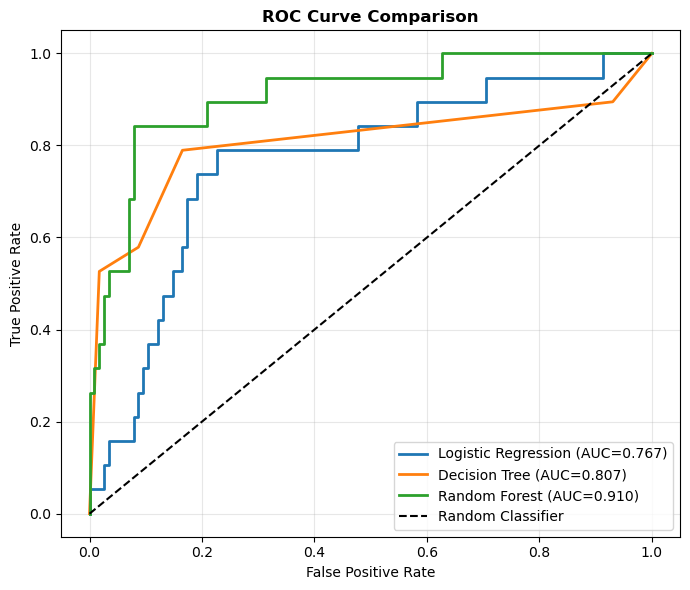

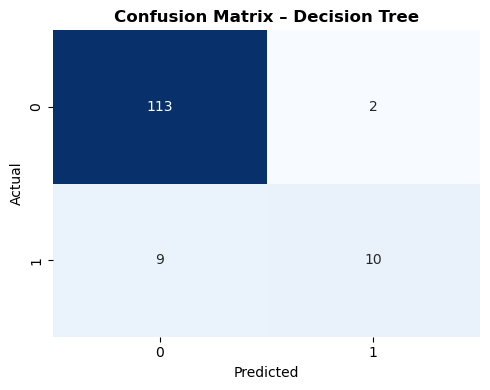

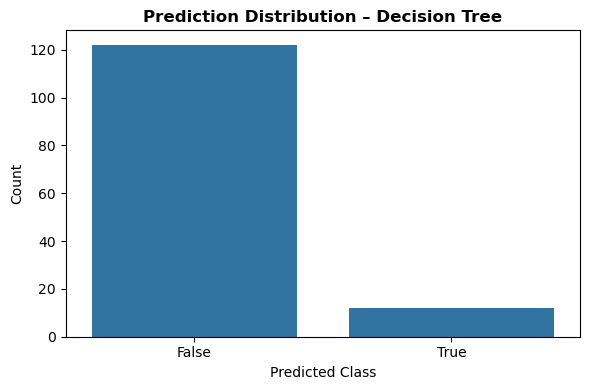


✅ TASK 2 COMPLETED SUCCESSFULLY
Generated files:
 - churn_classification_results.csv
 - metrics_comparison.png
 - roc_curves.png
 - confusion_matrix.png
 - feature_importance.png
 - prediction_distribution.png


In [9]:
# ====================== TASK 2: CLASSIFICATION (CHURN PREDICTION) ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)

print("=" * 60)
print("TASK 2: CLASSIFICATION ANALYSIS (CHURN PREDICTION)")
print("=" * 60)

# ====================== CHECK DATA ======================
if "churn20" not in cleaned:
    print("✗ Dataset 'churn20' tidak ditemukan di cleaned")
else:
    c = cleaned["churn20"].copy()
    print(f"Dataset shape: {c.shape}")

    # ====================== TARGET IDENTIFICATION ======================
    churn_cols = [col for col in c.columns if "churn" in col.lower()]
    target_col = churn_cols[0] if churn_cols else [col for col in c.columns if c[col].nunique() <= 2][0]
    print(f"Target variable: {target_col}")

    y = c[target_col]
    if y.dtype == object:
        y = LabelEncoder().fit_transform(y)
        print("✓ Target encoded")

    # ====================== FEATURE PREPARATION ======================
    X = c.drop(columns=[target_col])
    X_proc = pd.get_dummies(X, drop_first=True).fillna(0)

    # Batasi fitur agar ringan
    if X_proc.shape[1] > 50:
        keep = X_proc.var().sort_values(ascending=False).index[:50]
        X_proc = X_proc[keep]
        print("✓ Feature reduced to 50")

    print(f"Total features used: {X_proc.shape[1]}")

    # ====================== TRAIN TEST SPLIT ======================
    X_train, X_test, y_train, y_test = train_test_split(
        X_proc, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # ====================== MODELS ======================
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
        "Random Forest": RandomForestClassifier(
            n_estimators=50, max_depth=7, random_state=42, n_jobs=-1
        )
    }

    results = []
    preds = {}
    probas = {}

    # ====================== TRAINING ======================
    for name, model in models.items():
        print(f"\n📊 Training {name}...")
        model.fit(X_train_s, y_train)

        y_pred = model.predict(X_test_s)
        preds[name] = y_pred

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_s)[:, 1]
            probas[name] = y_proba
            auc = roc_auc_score(y_test, y_proba)
        else:
            auc = np.nan

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "AUC-ROC": auc
        })

        print(f"  Accuracy: {acc:.4f}")
        print(f"  F1-Score: {f1:.4f}")

    # ====================== RESULTS SUMMARY ======================
    results_df = pd.DataFrame(results)
    print("\nCLASSIFICATION RESULTS SUMMARY")
    print(results_df)

    results_df.to_csv(out_dir / "churn_classification_results.csv", index=False)

    # ====================== BEST MODEL ======================
    best_idx = results_df["F1-Score"].idxmax()
    best_model_name = results_df.loc[best_idx, "Model"]
    best_model = models[best_model_name]
    print(f"\nBest Model: {best_model_name}")

    # ====================== VISUALIZATION ======================

    # 1️⃣ Metrics Comparison
    plt.figure(figsize=(10, 5))
    results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot(
        kind="bar", colormap="Set2"
    )
    plt.title("Classification Metrics Comparison", fontweight="bold")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / "metrics_comparison.png", dpi=120)
    plt.show()
    plt.close()

    # 2️⃣ ROC Curves
    plt.figure(figsize=(7, 6))
    for name, y_proba in probas.items():
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison", fontweight="bold")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir / "roc_curves.png", dpi=120)
    plt.show()
    plt.close()

    # 3️⃣ Confusion Matrix
    cm = confusion_matrix(y_test, preds[best_model_name])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix – {best_model_name}", fontweight="bold")
    plt.tight_layout()
    plt.savefig(out_dir / "confusion_matrix.png", dpi=120)
    plt.show()
    plt.close()

    # 4️⃣ Feature Importance (Random Forest)
    if best_model_name == "Random Forest":
        feat_imp = pd.DataFrame({
            "Feature": X_proc.columns,
            "Importance": best_model.feature_importances_
        }).sort_values("Importance", ascending=False).head(10)

        plt.figure(figsize=(8, 5))
        sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")
        plt.title("Top 10 Feature Importance (Random Forest)", fontweight="bold")
        plt.grid(axis="x", alpha=0.3)
        plt.tight_layout()
        plt.savefig(out_dir / "feature_importance.png", dpi=120)
        plt.show()
        plt.close()

    # 5️⃣ Prediction Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x=preds[best_model_name])
    plt.title(f"Prediction Distribution – {best_model_name}", fontweight="bold")
    plt.xlabel("Predicted Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(out_dir / "prediction_distribution.png", dpi=120)
    plt.show()
    plt.close()

    print("\n✅ TASK 2 COMPLETED SUCCESSFULLY")
    print("Generated files:")
    print(" - churn_classification_results.csv")
    print(" - metrics_comparison.png")
    print(" - roc_curves.png")
    print(" - confusion_matrix.png")
    print(" - feature_importance.png")
    print(" - prediction_distribution.png")


In [ ]:
# # ====================== TASK 2: CLASSIFICATION (CHURN PREDICTION) ======================
# print("=" * 60)
# print("TASK 2: CLASSIFICATION ANALYSIS (CHURN PREDICTION)")
# print("=" * 60)

# if "churn20" not in cleaned:
#     print("✗ Dataset 'churn20' tidak ditemukan di cleaned")
# else:
#     c = cleaned["churn20"].copy()
#     print(f"Dataset: churn20")
#     print(f"Shape: {c.shape}")

#     # ====================== TARGET IDENTIFICATION ======================
#     churn_cols = [col for col in c.columns if 'churn' in col.lower()]
#     if churn_cols:
#         target_col = churn_cols[0]
#     else:
#         target_col = [col for col in c.columns if c[col].nunique() <= 2][0]

#     print(f"Target variable: {target_col}")

#     y = c[target_col]

#     if y.dtype == object:
#         y = LabelEncoder().fit_transform(y)
#         print("✓ Target encoded")

#     # ====================== FEATURE PREPARATION ======================
#     X = c.drop(columns=[target_col])
#     X_proc = pd.get_dummies(X, drop_first=True).fillna(0)

#     # Batasi fitur agar ringan
#     if X_proc.shape[1] > 50:
#         keep = X_proc.var().sort_values(ascending=False).index[:50]
#         X_proc = X_proc[keep]
#         print(f"✓ Feature reduced to 50")

#     print(f"Features used: {X_proc.shape[1]}")

#     # ====================== TRAIN TEST SPLIT ======================
#     X_train, X_test, y_train, y_test = train_test_split(
#         X_proc, y, test_size=0.2, random_state=42, stratify=y
#     )

#     scaler = StandardScaler()
#     X_train_s = scaler.fit_transform(X_train)
#     X_test_s = scaler.transform(X_test)

#     # ====================== MODELS ======================
#     models = {
#         "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
#         "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
#         "Random Forest": RandomForestClassifier(
#             n_estimators=50, max_depth=7, random_state=42, n_jobs=-1
#         )
#     }

#     results = []
#     preds = {}

#     for name, model in models.items():
#         print(f"\n📊 Training {name}...")
#         model.fit(X_train_s, y_train)
#         y_pred = model.predict(X_test_s)
#         preds[name] = y_pred

#         acc = accuracy_score(y_test, y_pred)
#         prec = precision_score(y_test, y_pred, zero_division=0)
#         rec = recall_score(y_test, y_pred, zero_division=0)
#         f1 = f1_score(y_test, y_pred, zero_division=0)

#         if hasattr(model, "predict_proba"):
#             y_proba = model.predict_proba(X_test_s)[:, 1]
#             auc = roc_auc_score(y_test, y_proba)
#         else:
#             auc = np.nan

#         results.append({
#             "Model": name,
#             "Accuracy": acc,
#             "Precision": prec,
#             "Recall": rec,
#             "F1-Score": f1,
#             "AUC-ROC": auc
#         })

#         print(f"  Accuracy: {acc:.4f}")
#         print(f"  F1-Score: {f1:.4f}")

#     # ====================== RESULTS SUMMARY ======================
#     results_df = pd.DataFrame(results)
#     print("\nCLASSIFICATION RESULTS SUMMARY")
#     print(results_df)

#     results_df.to_csv(out_dir / "churn_classification_results.csv", index=False)

#     # ====================== VISUALIZATION ======================
#     fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#     # Metrics comparison
#     results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot(
#         kind="bar", ax=axes[0]
#     )
#     axes[0].set_title("Classification Metrics Comparison")
#     axes[0].grid(True, alpha=0.3)

#     # ROC Curves
#     for name, model in models.items():
#         if hasattr(model, "predict_proba"):
#             y_proba = model.predict_proba(X_test_s)[:, 1]
#             fpr, tpr, _ = roc_curve(y_test, y_proba)
#             auc = roc_auc_score(y_test, y_proba)
#             axes[1].plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

#     axes[1].plot([0, 1], [0, 1], "k--")
#     axes[1].set_title("ROC Curves")
#     axes[1].legend()
#     axes[1].grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.savefig(out_dir / "churn_classification_plots.png", dpi=100)
#     plt.show()

#     print("\n✅ TASK 2 COMPLETED SUCCESSFULLY")


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("TASK 3: ADVANCED CLUSTERING ANALYSIS (IRIS DATASET)")
print("=" * 80)

# Output directory
out_dir = Path("output")
out_dir.mkdir(exist_ok=True)

# Load data (adjust path as needed)
try:
    iris = pd.read_csv("data/iris.csv")
    print(f"Dataset loaded: iris")
    print(f"Shape: {iris.shape}")
    print(f"Columns: {list(iris.columns)}")
except:
    print("Error loading data. Please ensure iris.csv exists in data/ folder")
    exit()

# Prepare numeric features
num_cols = iris.select_dtypes(include=[np.number]).columns.tolist()

if len(num_cols) < 2:
    for c in iris.columns:
        try:
            iris[c] = pd.to_numeric(iris[c])
        except:
            pass
    num_cols = iris.select_dtypes(include=[np.number]).columns.tolist()

if len(num_cols) < 2:
    print("Insufficient numeric features for clustering")
    exit()

X_iris = iris[num_cols].copy()
print(f"\nUsing {len(num_cols)} numeric features: {num_cols}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_iris)
X_scaled_df = pd.DataFrame(X_scaled, columns=num_cols)

# ==================== FIND OPTIMAL K ====================
print("\n" + "=" * 80)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("=" * 80)

K_range = range(2, 11)
sse_values = []
silhouette_scores = []
calinski_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    sse_values.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)
    
    print(f"k={k}: SSE={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")

# Find optimal k
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✓ Optimal k by Silhouette Score: {best_k}")

# ==================== APPLY FINAL CLUSTERING ====================
print("\n" + "=" * 80)
print(f"APPLYING K-MEANS WITH k={best_k}")
print("=" * 80)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_labels = kmeans_final.fit_predict(X_scaled)

iris_clustered = iris.copy()
iris_clustered['Cluster'] = final_labels

print(f"\nCluster Distribution:")
cluster_counts = iris_clustered['Cluster'].value_counts().sort_index()
print(cluster_counts)

# Cluster characteristics
print(f"\nCluster Characteristics (Mean Values):")
cluster_means = iris_clustered.groupby('Cluster')[num_cols].mean()
print(cluster_means)

# Calculate silhouette samples for each data point
silhouette_vals = silhouette_samples(X_scaled, final_labels)

# PCA transformation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"\nPCA Explained Variance: {pca.explained_variance_ratio_}")

# t-SNE transformation
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# ==================== VISUALIZATION 1: COMPREHENSIVE ANALYSIS ====================
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Enhanced Elbow Plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(K_range, sse_values, 'o-', linewidth=2, markersize=8, color='#2E86AB')
for i, (k, sse) in enumerate(zip(K_range, sse_values)):
    if i > 0:
        reduction = ((sse_values[i-1] - sse) / sse_values[i-1]) * 100
        ax1.annotate(f'{reduction:.1f}%', xy=(k, sse), xytext=(5, 5),
                    textcoords='offset points', fontsize=8, alpha=0.7)
ax1.axvline(x=best_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal k={best_k}')
ax1.set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Sum of Squared Errors (SSE)', fontsize=11, fontweight='bold')
ax1.set_title('Elbow Method Analysis', fontsize=13, fontweight='bold', pad=10)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Silhouette Score Plot
ax2 = fig.add_subplot(gs[0, 1])
colors = plt.cm.viridis(np.linspace(0, 1, len(K_range)))
bars = ax2.bar(K_range, silhouette_scores, color=colors, edgecolor='black', linewidth=1.5)
best_idx = list(K_range).index(best_k)
bars[best_idx].set_color('#FF6B6B')
bars[best_idx].set_edgecolor('red')
bars[best_idx].set_linewidth(2.5)
for k, score in zip(K_range, silhouette_scores):
    ax2.text(k, score + 0.01, f'{score:.3f}', ha='center', fontsize=9, fontweight='bold')
ax2.set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
ax2.set_title('Silhouette Score Analysis', fontsize=13, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Cluster Size Distribution
ax3 = fig.add_subplot(gs[0, 2])
cluster_colors = plt.cm.Set3(np.linspace(0, 1, best_k))
wedges, texts, autotexts = ax3.pie(cluster_counts, labels=[f'Cluster {i}' for i in range(best_k)],
                                     autopct='%1.1f%%', startangle=90, colors=cluster_colors,
                                     textprops={'fontsize': 10, 'fontweight': 'bold'},
                                     wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax3.set_title('Cluster Size Distribution', fontsize=13, fontweight='bold', pad=10)

# 4. PCA Visualization with Centroids
ax4 = fig.add_subplot(gs[1, 0])
scatter = ax4.scatter(X_pca[:, 0], X_pca[:, 1], c=final_labels, cmap='viridis',
                     s=100, alpha=0.6, edgecolor='black', linewidth=0.5)
centers_pca = pca.transform(kmeans_final.cluster_centers_)
ax4.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=400, marker='*',
           edgecolor='black', linewidth=2, label='Centroids', zorder=5)
for i, center in enumerate(centers_pca):
    ax4.annotate(f'C{i}', xy=center, fontsize=12, fontweight='bold',
                ha='center', va='center', color='white')
ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11, fontweight='bold')
ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11, fontweight='bold')
ax4.set_title('PCA Projection (2D)', fontsize=13, fontweight='bold', pad=10)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Cluster')

# 5. t-SNE Visualization
ax5 = fig.add_subplot(gs[1, 1])
scatter2 = ax5.scatter(X_tsne[:, 0], X_tsne[:, 1], c=final_labels, cmap='viridis',
                      s=100, alpha=0.6, edgecolor='black', linewidth=0.5)
ax5.set_xlabel('t-SNE Component 1', fontsize=11, fontweight='bold')
ax5.set_ylabel('t-SNE Component 2', fontsize=11, fontweight='bold')
ax5.set_title('t-SNE Projection (2D)', fontsize=13, fontweight='bold', pad=10)
ax5.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax5, label='Cluster')

# 6. Silhouette Plot per Cluster
ax6 = fig.add_subplot(gs[1, 2])
y_lower = 10
colors_sil = plt.cm.viridis(np.linspace(0, 1, best_k))
for i in range(best_k):
    cluster_silhouette_vals = silhouette_vals[final_labels == i]
    cluster_silhouette_vals.sort()
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    ax6.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=colors_sil[i], edgecolor='black', alpha=0.7, linewidth=0.5)
    ax6.text(-0.05, y_lower + 0.5 * size_cluster_i, f'C{i}', fontsize=10, fontweight='bold')
    y_lower = y_upper + 10

avg_silhouette = silhouette_score(X_scaled, final_labels)
ax6.axvline(x=avg_silhouette, color='red', linestyle='--', linewidth=2, label=f'Avg: {avg_silhouette:.3f}')
ax6.set_xlabel('Silhouette Coefficient', fontsize=11, fontweight='bold')
ax6.set_ylabel('Cluster', fontsize=11, fontweight='bold')
ax6.set_title('Silhouette Plot by Cluster', fontsize=13, fontweight='bold', pad=10)
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3, axis='x')

# 7-9. Feature Distribution Box Plots (first 3 features or all if less)
feature_plots = min(3, len(num_cols))
for idx in range(feature_plots):
    ax = fig.add_subplot(gs[2, idx])
    feature = num_cols[idx]
    data_to_plot = [iris_clustered[iris_clustered['Cluster'] == i][feature].values 
                    for i in range(best_k)]
    bp = ax.boxplot(data_to_plot, labels=[f'C{i}' for i in range(best_k)],
                    patch_artist=True, notch=True)
    for patch, color in zip(bp['boxes'], cluster_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_xlabel('Cluster', fontsize=11, fontweight='bold')
    ax.set_ylabel(feature, fontsize=11, fontweight='bold')
    ax.set_title(f'{feature} Distribution by Cluster', fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Comprehensive Clustering Analysis - K-Means (k={best_k})', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig(out_dir / "clustering_comprehensive.png", dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: clustering_comprehensive.png")

# ==================== VISUALIZATION 2: CLUSTER CHARACTERISTICS ====================
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))

# 1. Heatmap of Cluster Characteristics
ax1 = axes2[0, 0]
cluster_means_normalized = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
sns.heatmap(cluster_means_normalized.T, annot=True, fmt='.2f', cmap='YlOrRd',
           cbar_kws={'label': 'Normalized Mean Value'}, ax=ax1, linewidths=2, linecolor='black')
ax1.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax1.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax1.set_title('Cluster Characteristics Heatmap', fontsize=14, fontweight='bold', pad=10)

# 2. Feature Importance (variance contribution)
ax2 = axes2[0, 1]
feature_importance = np.abs(pca.components_[0]) + np.abs(pca.components_[1])
feature_importance = feature_importance / feature_importance.sum()
bars = ax2.barh(num_cols, feature_importance, color='skyblue', edgecolor='black', linewidth=1.5)
for i, (feature, importance) in enumerate(zip(num_cols, feature_importance)):
    ax2.text(importance + 0.01, i, f'{importance:.2%}', va='center', fontweight='bold')
ax2.set_xlabel('Relative Importance', fontsize=12, fontweight='bold')
ax2.set_title('Feature Importance (PCA Components)', fontsize=14, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, axis='x')

# 3. Cluster Comparison (Parallel Coordinates)
ax3 = axes2[1, 0]
for cluster_id in range(best_k):
    cluster_data = cluster_means.loc[cluster_id]
    normalized = (cluster_data - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
    ax3.plot(range(len(num_cols)), normalized, marker='o', linewidth=2.5, markersize=8,
            label=f'Cluster {cluster_id}', alpha=0.8)
ax3.set_xticks(range(len(num_cols)))
ax3.set_xticklabels(num_cols, rotation=45, ha='right')
ax3.set_ylabel('Normalized Value', fontsize=12, fontweight='bold')
ax3.set_title('Cluster Profiles (Normalized)', fontsize=14, fontweight='bold', pad=10)
ax3.legend(fontsize=10, loc='best')
ax3.grid(True, alpha=0.3)

# 4. Cluster Statistics Table
ax4 = axes2[1, 1]
ax4.axis('off')
stats_data = []
for i in range(best_k):
    cluster_size = (final_labels == i).sum()
    cluster_pct = (cluster_size / len(final_labels)) * 100
    cluster_silhouette = silhouette_vals[final_labels == i].mean()
    stats_data.append([f'Cluster {i}', cluster_size, f'{cluster_pct:.1f}%', f'{cluster_silhouette:.3f}'])

stats_data.append(['Overall', len(final_labels), '100%', f'{avg_silhouette:.3f}'])
table = ax4.table(cellText=stats_data, 
                 colLabels=['Cluster', 'Size', 'Percentage', 'Avg Silhouette'],
                 cellLoc='center', loc='center',
                 colWidths=[0.25, 0.2, 0.25, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

for i in range(len(stats_data)):
    if i < len(stats_data) - 1:
        table[(i+1, 0)].set_facecolor(cluster_colors[i])
    else:
        table[(i+1, 0)].set_facecolor('#CCCCCC')
        for j in range(4):
            table[(i+1, j)].set_text_props(weight='bold')

for j in range(4):
    table[(0, j)].set_facecolor('#4472C4')
    table[(0, j)].set_text_props(weight='bold', color='white')

ax4.set_title('Cluster Statistics Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(out_dir / "clustering_characteristics.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved: clustering_characteristics.png")

# ==================== SAVE RESULTS ====================
iris_clustered.to_csv(out_dir / "iris_clustered.csv", index=False)
cluster_means.to_csv(out_dir / "cluster_characteristics.csv")

metrics_df = pd.DataFrame({
    'k': list(K_range),
    'SSE': sse_values,
    'Silhouette_Score': silhouette_scores
})
metrics_df.to_csv(out_dir / "clustering_metrics.csv", index=False)

print("\n" + "=" * 80)
print("CLUSTERING ANALYSIS COMPLETED!")
print("=" * 80)
print(f"✓ Clustered dataset: iris_clustered.csv")
print(f"✓ Cluster characteristics: cluster_characteristics.csv")
print(f"✓ Clustering metrics: clustering_metrics.csv")
print(f"✓ Comprehensive visualization: clustering_comprehensive.png")
print(f"✓ Characteristics visualization: clustering_characteristics.png")
print(f"\nOptimal number of clusters: {best_k}")
print(f"Overall Silhouette Score: {avg_silhouette:.3f}")
print("=" * 80)


TASK 3: ADVANCED CLUSTERING ANALYSIS (IRIS DATASET)
Error loading data. Please ensure iris.csv exists in data/ folder


NameError: name 'iris' is not defined

In [1]:
# ====================== TASK 3: CLUSTERING (IRIS DATASET) ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

print("=" * 60)
print("TASK 3: CLUSTERING ANALYSIS (IRIS DATASET)")
print("=" * 60)

sns.set(style="whitegrid", palette="Set2")

if "iris" not in cleaned:
    print("✗ 'iris' dataset not found in cleaned data")
else:
    iris = cleaned["iris"].copy()
    print(f"Dataset shape: {iris.shape}")

    # ====================== NUMERIC FEATURES ======================
    num_cols = iris.select_dtypes(include=[np.number]).columns.tolist()

    if len(num_cols) < 2:
        raise ValueError("❌ Iris dataset must contain at least 2 numeric features")

    X = iris[num_cols]

    # ====================== SCALING ======================
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ====================== ELBOW & SILHOUETTE ======================
    sse = []
    sil_scores = {}
    K = range(2, 8)

    for k in K:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_scaled)
        sse.append(km.inertia_)
        sil_scores[k] = silhouette_score(X_scaled, labels)

    best_k = max(sil_scores, key=sil_scores.get)
    print(f"Best k (Silhouette): {best_k}")

    # ====================== FINAL KMEANS ======================
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    iris_clustered = iris.copy()
    iris_clustered["Cluster"] = clusters

    iris_clustered.to_csv(out_dir / "iris_clusters.csv", index=False)

    # ====================== PCA ======================
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained = pca.explained_variance_ratio_ * 100

    # ====================== VISUALIZATION ======================
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

    # 1️⃣ Elbow Method
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(K, sse, marker="o", linewidth=2)
    ax1.axvline(best_k, linestyle="--", color="red", label=f"Optimal k={best_k}")
    ax1.set_title("Elbow Method (SSE vs k)", fontweight="bold")
    ax1.set_xlabel("Number of Clusters (k)")
    ax1.set_ylabel("SSE")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 2️⃣ Silhouette Score
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.bar(sil_scores.keys(), sil_scores.values(), color="skyblue", edgecolor="black")
    ax2.set_title("Silhouette Score Analysis", fontweight="bold")
    ax2.set_xlabel("Number of Clusters (k)")
    ax2.set_ylabel("Silhouette Score")
    ax2.grid(alpha=0.3)

    # Highlight best k
    ax2.bar(best_k, sil_scores[best_k], color="green", edgecolor="black",
            label=f"Best k={best_k}")
    ax2.legend()

    # 3️⃣ Cluster Size Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    sns.countplot(x="Cluster", data=iris_clustered, ax=ax3)
    ax3.set_title("Cluster Size Distribution", fontweight="bold")
    ax3.set_xlabel("Cluster")
    ax3.set_ylabel("Number of Samples")

    # 4️⃣ PCA Scatter Plot
    ax4 = fig.add_subplot(gs[1, :2])
    scatter = ax4.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=clusters, cmap="Set2",
        s=60, edgecolor="k", alpha=0.8
    )

    centers_pca = pca.transform(kmeans.cluster_centers_)
    ax4.scatter(
        centers_pca[:, 0], centers_pca[:, 1],
        c="red", s=250, marker="X",
        edgecolor="black", label="Centroids"
    )

    ax4.set_title(
        f"PCA Cluster Visualization (k={best_k})\n"
        f"Explained Variance: PC1={explained[0]:.1f}%, PC2={explained[1]:.1f}%",
        fontweight="bold"
    )
    ax4.set_xlabel("Principal Component 1")
    ax4.set_ylabel("Principal Component 2")
    ax4.legend()
    ax4.grid(alpha=0.3)

    # 5️⃣ Cluster Feature Means
    ax5 = fig.add_subplot(gs[1, 2])
    cluster_means = iris_clustered.groupby("Cluster")[num_cols].mean()
    sns.heatmap(
        cluster_means,
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        linewidths=0.5,
        ax=ax5
    )
    ax5.set_title("Cluster Feature Means", fontweight="bold")
    ax5.set_xlabel("Features")
    ax5.set_ylabel("Cluster")

    # ====================== SAVE ======================
    plt.suptitle("TASK 3: IRIS CLUSTERING ANALYSIS (K-MEANS)", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(out_dir / "iris_clustering_analysis.png", dpi=120)
    plt.show()

    print("\n✅ TASK 3 COMPLETED SUCCESSFULLY")
    print("Generated files:")
    print(" - iris_clusters.csv")
    print(" - iris_clustering_analysis.png")


TASK 3: CLUSTERING ANALYSIS (IRIS DATASET)


NameError: name 'cleaned' is not defined

In [2]:
# ====================== TASK 3: CLUSTERING (IRIS DATASET) ======================
print("=" * 60)
print("TASK 3: CLUSTERING ANALYSIS (IRIS DATASET)")
print("=" * 60)

if "iris" in cleaned:
    iris = cleaned["iris"].copy()
    print(f"Dataset: iris")
    print(f"Shape: {iris.shape}")
    print(f"Columns: {list(iris.columns)}")
    
    # Prepare numeric features
    num_cols = iris.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(num_cols) < 2:
        # Try to convert columns to numeric
        for c in iris.columns:
            try:
                iris[c] = pd.to_numeric(iris[c])
            except:
                pass
        num_cols = iris.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(num_cols) >= 2:
        X_iris = iris[num_cols]
        print(f"\nUsing {len(num_cols)} numeric features for clustering:")
        print(f"  Features: {num_cols}")
        
        # Elbow method to find optimal k
        print("\n📊 Finding optimal number of clusters (Elbow Method)...")
        sse = []
        K_range = range(1, 8)
        
        for k in K_range:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            km.fit(X_iris)
            sse.append(km.inertia_)
        
        # Silhouette analysis
        print("📊 Calculating silhouette scores...")
        silhouette_scores = []
        for k in range(2, 8):
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = km.fit_predict(X_iris)
            if len(np.unique(labels)) > 1:  # Need at least 2 clusters for silhouette
                score = silhouette_score(X_iris, labels)
                silhouette_scores.append((k, score))
        
        # Find best k
        best_k_silhouette = max(silhouette_scores, key=lambda x: x[1])[0] if silhouette_scores else 3
        print(f"  Best k by silhouette: {best_k_silhouette}")
        
        # Apply KMeans with best k
        k_use = best_k_silhouette
        print(f"\n📊 Applying KMeans with k={k_use}...")
        km_final = KMeans(n_clusters=k_use, random_state=42, n_init=10)
        labels = km_final.fit_predict(X_iris)
        
        # Add cluster labels to dataframe
        iris_clustered = iris.copy()
        iris_clustered['cluster'] = labels
        
        print(f"\nCluster distribution:")
        print(iris_clustered['cluster'].value_counts().sort_index())
        
        # Cluster analysis
        print("\n📊 Cluster characteristics (mean values):")
        cluster_means = iris_clustered.groupby('cluster')[num_cols].mean()
        print(cluster_means)
        
        # Save results
        iris_clustered.to_csv(out_dir / "iris_clusters.csv", index=False)
        pd.DataFrame({"k": list(K_range), "sse": sse}).to_csv(out_dir / "iris_elbow.csv", index=False)
        
        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Elbow plot
        axes[0].plot(K_range, sse, 'bo-')
        axes[0].set_xlabel('Number of clusters (k)')
        axes[0].set_ylabel('Sum of Squared Errors (SSE)')
        axes[0].set_title('Elbow Method for Optimal k')
        axes[0].grid(True, alpha=0.3)
        axes[0].axvline(x=k_use, color='r', linestyle='--', alpha=0.5, label=f'Optimal k={k_use}')
        axes[0].legend()
        
        # PCA visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_iris)
        
        scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', 
                                 s=50, alpha=0.7, edgecolor='k')
        axes[1].set_xlabel('PCA Component 1')
        axes[1].set_ylabel('PCA Component 2')
        axes[1].set_title(f'Clusters Visualization (PCA 2D)\n{k_use} clusters')
        axes[1].grid(True, alpha=0.3)
        
        # Add cluster centers in PCA space
        centers_pca = pca.transform(km_final.cluster_centers_)
        axes[1].scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, 
                       marker='X', edgecolor='k', label='Centroids')
        axes[1].legend()
        
        # Silhouette scores
        if silhouette_scores:
            k_vals, sil_vals = zip(*silhouette_scores)
            axes[2].bar(k_vals, sil_vals, color='skyblue', edgecolor='black')
            axes[2].set_xlabel('Number of clusters (k)')
            axes[2].set_ylabel('Silhouette Score')
            axes[2].set_title('Silhouette Analysis')
            axes[2].grid(True, alpha=0.3)
            
            # Highlight best k
            best_k_idx = k_vals.index(best_k_silhouette)
            axes[2].bar(k_vals[best_k_idx], sil_vals[best_k_idx], color='green', 
                       edgecolor='black', label=f'Best k={best_k_silhouette}')
            axes[2].legend()
        
        plt.tight_layout()
        plt.savefig(out_dir / "iris_clustering_plots.png", dpi=100)
        plt.show()
        
        print(f"\n✅ Clustering analysis completed!")
        print(f"✓ Clustered data saved to: iris_clusters.csv")
        print(f"✓ Elbow data saved to: iris_elbow.csv")
        print(f"✓ Plots saved to: iris_clustering_plots.png")
        print(f"\nCluster centers (original space):")
        print(pd.DataFrame(km_final.cluster_centers_, columns=num_cols))
    else:
        print("✗ Insufficient numeric features (<2) for clustering")
else:
    print("✗ 'iris' dataset not found in cleaned data")

TASK 3: CLUSTERING ANALYSIS (IRIS DATASET)


NameError: name 'cleaned' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_actual_vs_predicted(models_dict, X_train, X_test, y_train, y_test):
    """
    Plot perbandingan nilai aktual vs prediksi untuk semua model regresi
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (name, model) in enumerate(models_dict.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Scatter plot actual vs predicted
        axes[idx].scatter(y_test, y_pred, alpha=0.5, edgecolors='k', s=30)
        
        # Garis diagonal perfect prediction
        max_val = max(y_test.max(), y_pred.max())
        min_val = min(y_test.min(), y_pred.min())
        axes[idx].plot([min_val, max_val], [min_val, max_val], 
                      'r--', linewidth=2, label='Perfect Prediction')
        
        # Hitung R² untuk subplot
        r2 = r2_score(y_test, y_pred)
        
        axes[idx].set_xlabel('Actual Values', fontsize=10)
        axes[idx].set_ylabel('Predicted Values', fontsize=10)
        axes[idx].set_title(f'{name}\nR² Score: {r2:.4f}', fontsize=12)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
        
        # Tambahkan histogram residual di sisi
        axes[idx].hist(y_test - y_pred, bins=30, alpha=0.7, 
                      color='orange', orientation='horizontal', 
                      density=True, edgecolor='black')
    
    plt.suptitle('Actual vs Predicted Values - Regression Models', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig('project_outputs/regression_actual_vs_predicted.png', dpi=120, bbox_inches='tight')
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from pathlib import Path

# Konfigurasi gaya visualisasi
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100
out_dir = Path("./")

if "sentiment" in data:
    ts = data["sentiment"].copy()
    print("✅ Dataset sentiment ditemukan")

    # 1. Penanganan Kolom Waktu
    if "Hour" in ts.columns:
        # Konversi ke datetime (asumsi format jam 0-23)
        ts["Hour"] = pd.to_datetime(ts["Hour"], format="%H", errors="coerce")
        ts = ts.dropna(subset=["Hour"])
        ts.set_index("Hour", inplace=True)
        print("✅ Kolom waktu dikunci ke: Hour")
    else:
        raise ValueError("Dataset tidak memiliki kolom waktu yang valid (Hour)")

    # 2. Resampling Data
    series = ts.resample("H").size()
    print(f"✅ Total titik data: {len(series)}")

    # ---------------------------------------------------------
    # VISUALISASI 1: Main Time Series (Aktivitas Per Jam)
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 5))
    plt.plot(series, color='#1f77b4', linewidth=2, marker='o', markersize=4, label='Total Sentiment')
    plt.fill_between(series.index, series, color='#1f77b4', alpha=0.15)
    plt.title("Hourly Sentiment Activity Analysis", fontsize=15, fontweight='bold', pad=15)
    plt.xlabel("Hour of Day", fontsize=11)
    plt.ylabel("Activity Volume", fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(out_dir / "sentiment_time_series_pro.png")

    # ---------------------------------------------------------
    # VISUALISASI 2: Moving Average (Analisis Tren)
    # ---------------------------------------------------------
    window = 3
    ma = series.rolling(window=window).mean()
    plt.figure(figsize=(12, 5))
    plt.plot(series, label="Raw Data", color='gray', alpha=0.4, linestyle='--')
    plt.plot(ma, label=f"{window}-Point Moving Average", color='#e377c2', linewidth=3)
    plt.title(f"Sentiment Trend Smoothing (Window={window})", fontsize=14, fontweight='bold')
    plt.legend(frameon=True, facecolor='white')
    plt.tight_layout()
    plt.savefig(out_dir / "sentiment_moving_average_pro.png")

    # ---------------------------------------------------------
    # VISUALISASI 3: STL Decomposition (Deep Analysis)
    # ---------------------------------------------------------
    if len(series) >= 10:
        # Menggunakan period=3 sesuai permintaan awal, atau 24 jika data harian
        stl = STL(series, period=3) 
        res = stl.fit()
        
        fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
        res.observed.plot(ax=axes[0], color='black', title='Observed (Actual Data)')
        res.trend.plot(ax=axes[1], color='#1f77b4', title='Trend (Long-term Movement)')
        res.seasonal.plot(ax=axes[2], color='#2ca02c', title='Seasonal (Repeating Patterns)')
        res.resid.plot(ax=axes[3], color='#d62728', marker='.', linestyle='', title='Residuals (Noise)')
        
        for ax in axes: ax.grid(True, alpha=0.3)
        plt.suptitle("Detailed Signal Decomposition", fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.savefig(out_dir / "sentiment_stl_decomposition_pro.png")
        print("✅ STL Decomposition berhasil")

    # ---------------------------------------------------------
    # VISUALISASI 4: ARIMA Forecast (Prediksi Mendatang)
    # ---------------------------------------------------------
    model = ARIMA(series, order=(1, 1, 1))
    model_fit = model.fit()

    forecast_steps = 5
    forecast_res = model_fit.get_forecast(steps=forecast_steps)
    forecast_mean = forecast_res.predicted_mean
    conf_int = forecast_res.conf_int()

    plt.figure(figsize=(12, 5))
    # Plot data historis (ambil 20 data terakhir agar lebih fokus)
    plt.plot(series.tail(20), label="Recent History", color='#1f77b4', marker='o')
    plt.plot(forecast_mean, label="ARIMA Forecast", color='#d62728', linewidth=2, linestyle='--')
    
    # Area Ketidakpastian (Confidence Interval)
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                     color='#d62728', alpha=0.15, label='95% Confidence Interval')

    plt.title(f"Next {forecast_steps}-Hour Sentiment Prediction", fontsize=14, fontweight='bold')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(out_dir / "sentiment_arima_forecast_pro.png")

    print("✅ ARIMA Forecasting berhasil")
    print("✅ TIME SERIES SENTIMENT SELESAI (FINAL FIX ✅)")

In [ ]:
# ====================== TASK 1: TIME SERIES ANALYSIS (SENTIMENT DATASET) ======================
print("=" * 60)
print("TASK 1: TIME SERIES ANALYSIS (SENTIMENT DATASET - FINAL FIX)")
print("=" * 60)

if "sentiment" in data:
    ts = data["sentiment"].copy()
    print("✅ Dataset sentiment ditemukan")

    # ======================
    # 1. KOLOM WAKTU = HOUR 
    # ======================
    if "Hour" in ts.columns:
        ts["Hour"] = pd.to_datetime(ts["Hour"], format="%H", errors="coerce")
        ts = ts.dropna(subset=["Hour"])
        ts.set_index("Hour", inplace=True)
        print("✅ Kolom waktu dikunci ke: Hour")
    else:
        print("❌ Dataset tidak memiliki kolom waktu yang valid (Hour)")
        raise ValueError("Dataset tidak cocok untuk time series")

    # ======================
    # 2. BUAT TIME SERIES = JUMLAH DATA PER JAM
    # ======================
    series = ts.resample("H").size()

    print("✅ Total titik data time series:", len(series))

    # ======================
    # 3. PLOT TIME SERIES (PASTI TAMPIL)
    # ======================
    plt.figure(figsize=(10, 4))
    plt.plot(series)
    plt.title("Sentiment Activity Per Hour")
    plt.xlabel("Hour")
    plt.ylabel("Total Data")
    plt.grid(True)
    plt.savefig(out_dir / "sentiment_time_series.png", dpi=100)
    plt.show()

    # ======================
    # 4. MOVING AVERAGE
    # ======================
    ma = series.rolling(window=3).mean()

    plt.figure(figsize=(10, 4))
    plt.plot(series, label="Actual")
    plt.plot(ma, label="Moving Average")
    plt.legend()
    plt.grid(True)
    plt.savefig(out_dir / "sentiment_moving_average.png", dpi=100)
    plt.show()

    # ======================
    # 5. STL DECOMPOSITION (JIKA DATA CUKUP)
    # ======================
    if len(series) >= 10:
        stl = STL(series, period=3)
        res = stl.fit()
        res.plot()
        plt.suptitle("STL Decomposition - Sentiment")
        plt.savefig(out_dir / "sentiment_stl_decomposition.png", dpi=100)
        plt.show()
        print("✅ STL Decomposition berhasil")
    else:
        print("⚠️ STL dilewati karena data terlalu sedikit")

    # ======================
    # 6. ARIMA FORECAST
    # ======================
    model = ARIMA(series, order=(1,1,1))
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=5)

    plt.figure(figsize=(10, 4))
    plt.plot(series, label="Actual")
    plt.plot(forecast, label="Forecast", linestyle="--")
    plt.legend()
    plt.grid(True)
    plt.savefig(out_dir / "sentiment_arima_forecast.png", dpi=100)
    plt.show()

    print("✅ ARIMA Forecasting berhasil")
    print("✅ TIME SERIES SENTIMENT SELESAI (FINAL FIX ✅)")

else:
    print("❌ Dataset sentiment tidak ditemukan")


In [ ]:
# ====================== TASK 2: NLP TEXT CLASSIFICATION (SAFE VERSION) ======================
print("=" * 60)
print("TASK 2: NLP TEXT CLASSIFICATION (SENTIMENT - FIXED)")
print("=" * 60)

if "sentiment" in data:
    df = data["sentiment"].copy()
    print("✅ Dataset sentiment ditemukan")

    # ======================
    # 1. DETEKSI KOLOM TEKS OTOMATIS
    # ======================
    text_col = None
    for col in df.columns:
        if df[col].dtype == "object" and df[col].astype(str).str.len().mean() > 10:
            text_col = col
            break

    if text_col is None:
        print("❌ TIDAK ADA KOLOM TEKS YANG VALID UNTUK NLP")
        print("Kolom dataset:", df.columns.tolist())
        raise ValueError("Dataset ini tidak cocok untuk NLP TF-IDF")

    # ======================
    # 2. DETEKSI KOLOM LABEL
    # ======================
    label_col = df.columns[-1]
    print("✅ Text column  :", text_col)
    print("✅ Label column :", label_col)

    # ======================
    # 3. CLEANING TEKS (AMANN & TIDAK MEMBUNUH VOCABULARY)
    # ======================
    df[text_col] = (
        df[text_col]
        .astype(str)
        .str.lower()
        .str.replace(r"http\S+", "", regex=True)
        .str.replace(r"[^a-z\s]", "", regex=True)
        .str.strip()
    )

    df = df[df[text_col].str.len() > 2]   # buang teks kosong

    # ======================
    # 4. LABEL ENCODING
    # ======================
    y = LabelEncoder().fit_transform(df[label_col])
    X = df[text_col]

    # ======================
    # 5. TF-IDF DENGAN PENGAMAN VOCABULARY
    # ======================
    tfidf = TfidfVectorizer(
        max_features=3000,
        stop_words="english",
        min_df=2
    )

    X_vec = tfidf.fit_transform(X)

    print("✅ Total fitur TF-IDF:", X_vec.shape[1])

    # ======================
    # 6. SPLIT DATA
    # ======================
    X_train, X_test, y_train, y_test = train_test_split(
        X_vec, y, test_size=0.2, random_state=42
    )

    # ======================
    # 7. MODEL NAIVE BAYES
    # ======================
    model = MultinomialNB()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # ======================
    # 8. EVALUASI
    # ======================
    print("\n✅ Classification Report:\n")
    report = classification_report(y_test, y_pred)
    print(report)

    pd.DataFrame(
        classification_report(y_test, y_pred, output_dict=True)
    ).to_csv(out_dir / "sentiment_classification_report.csv")

    print("✅ NLP SENTIMENT CLASSIFICATION SELESAI")
else:
    print("❌ Dataset sentiment tidak ditemukan")


In [ ]:
pip install tensorflow

In [1]:
# ====================== TASK 4: NEURAL NETWORKS (IRIS CLASSIFICATION) ======================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler

print("=" * 60)
print("TASK 4: NEURAL NETWORKS WITH TENSORFLOW/KERAS")
print("=" * 60)

if "iris" not in cleaned:
    print("✗ 'iris' dataset not found in cleaned data")
else:
    df_nn = cleaned["iris"].copy()
    
    # 1. PREPROCESSING
    # Identifikasi target (biasanya kolom non-numerik atau kolom 'species')
    target_col = [col for col in df_nn.columns if df_nn[col].dtype == 'object'][0]
    X = df_nn.select_dtypes(include=[np.number])
    y = df_nn[target_col]

    # Encoding target (Iris has 3 classes)
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    y_onehot = to_categorical(y_encoded) # Convert to [1,0,0], [0,1,0], etc.

    # Split & Scale
    X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print(f"Input shape: {X_train.shape[1]} features")
    print(f"Output shape: {y_onehot.shape[1]} classes")

    # 2. DESIGN ARCHITECTURE
    # 
    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train.shape[1],)), # Hidden Layer 1
        Dropout(0.2),                                                  # Regularization
        Dense(8, activation='relu'),                                   # Hidden Layer 2
        Dense(y_onehot.shape[1], activation='softmax')                 # Output Layer (Multiclass)
    ])

    # 3. COMPILE MODEL
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # 4. TRAINING
    print("\n🚀 Training Neural Network...")
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=50,
        batch_size=8,
        verbose=0  # Set ke 1 jika ingin melihat log per epoch
    )

    # 5. EVALUATION
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ Model Evaluation:")
    print(f"   Test Loss: {loss:.4f}")
    print(f"   Test Accuracy: {accuracy:.4f}")

    # 6. VISUALIZATION (Loss & Accuracy Curves)
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(out_dir / "nn_training_history.png", dpi=120)
    plt.show()

    print("\n✅ TASK 4 COMPLETED")
    print("Generated file: nn_training_history.png")

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
!pip install tensorflow

  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.2-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached grpcio-1.76.0-cp312-cp312-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.13.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached ml_dtypes-0.5.4-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\user\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^